# MAT281 - Laboratorio N°11

<a id='p1'></a>
## I.- Problema 01

Lista de actos delictivos registrados por el Service de police de la Ville de Montréal (SPVM).


<img src="http://henriquecapriles.com/wp-content/uploads/2017/02/femina_detenida-1080x675.jpg" width="480" height="360" align="center"/>

El conjunto de datos en estudio `interventionscitoyendo.csv` corresponde a  todos los delitos entre 2015 y agosto de 2020en Montreal. Cada delito está asociado en grandes categorías, y hay información sobre la ubicación, el momento del día, etc.

> **Nota**: Para más información seguir el siguiente el [link](https://donnees.montreal.ca/ville-de-montreal/actes-criminels).

In [1]:
# librerias 

import os
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from metrics_regression import *
import warnings
warnings.filterwarnings("ignore")


# graficos incrustados
plt.style.use('fivethirtyeight')
%matplotlib inline

# parametros esteticos de seaborn
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (12, 4)})

In [2]:
# read data

validate_categorie = [
  'Introduction', 'Méfait','Vol dans / sur véhicule à moteur', 'Vol de véhicule à moteur',
]

df = pd.read_csv(os.path.join("data","interventionscitoyendo.csv"), sep=",", encoding='latin-1')
df.columns = df.columns.str.lower()
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

df = df.loc[lambda x: x['categorie'].isin(validate_categorie)]
df = df.sort_values(['categorie','date'])
df.head()

,categorie,date,quart,pdq,x,y,longitude,latitude
3462,Introduction,2015-01-01,jour,42.0,297210.375006,5.050179e+06,-73.597273,45.591480
8370,Introduction,2015-01-01,soir,13.0,297145.531007,5.032845e+06,-73.597834,45.435501
11968,Introduction,2015-01-01,nuit,8.0,289215.072000,5.036423e+06,-73.699308,45.467564
12763,Introduction,2015-01-01,soir,27.0,293203.472992,5.045436e+06,-73.648516,45.548740
13686,Introduction,2015-01-01,soir,44.0,298915.433995,5.046912e+06,-73.575381,45.562090


Como tenemos muchos datos por categoría a nivel de día, agruparemos a nivel de **semanas** y separaremos cada serie temporal.

In [3]:
cols = ['date','pdq']
y_s1 = df.loc[lambda x: x.categorie == validate_categorie[0] ][cols].set_index('date').resample('W').mean()
y_s2 = df.loc[lambda x: x.categorie == validate_categorie[1] ][cols].set_index('date').resample('W').mean()
y_s3 = df.loc[lambda x: x.categorie == validate_categorie[2] ][cols].set_index('date').resample('W').mean()
y_s4 = df.loc[lambda x: x.categorie == validate_categorie[3] ][cols].set_index('date').resample('W').mean()

El objetivo de este laboratorio es poder realizar un análisis completo del conjunto de datos en estudio, para eso debe responder las siguientes preguntas:

1. Realizar un gráfico para cada serie temporal $y\_{si}, i =1,2,3,4$.


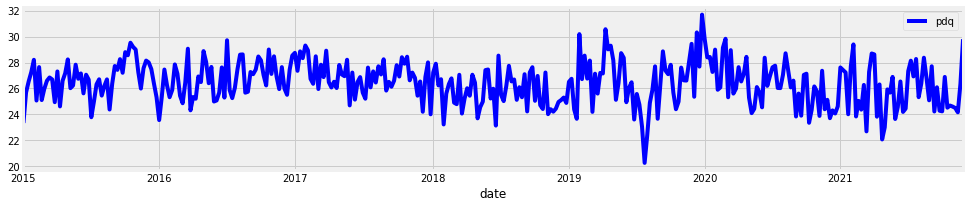

In [4]:
# graficar datos
y_s1.plot(figsize=(15, 3),color = 'blue')
plt.show()

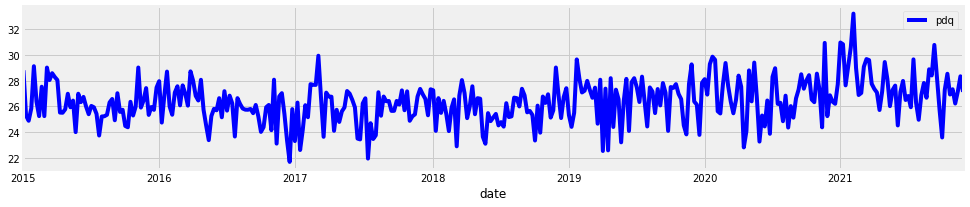

In [5]:
# graficar datos
y_s2.plot(figsize=(15, 3),color = 'blue')
plt.show()

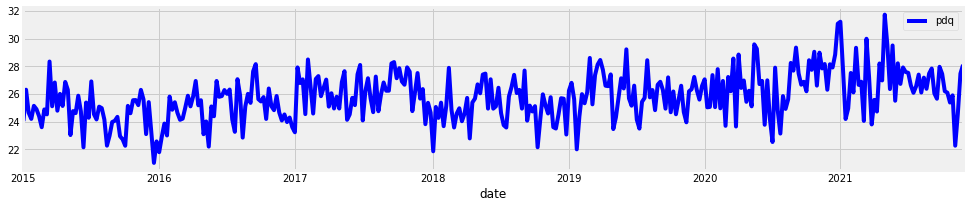

In [6]:
# graficar datos
y_s3.plot(figsize=(15, 3),color = 'blue')
plt.show()

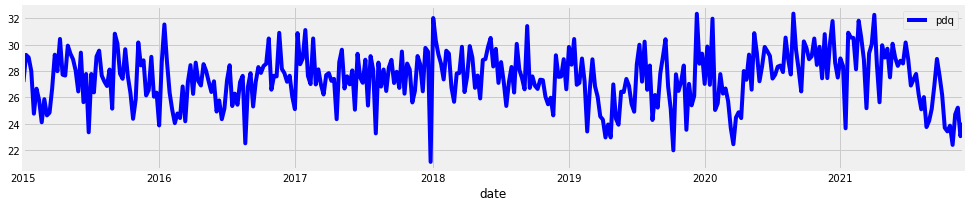

In [7]:
# graficar datos
y_s4.plot(figsize=(15, 3),color = 'blue')
plt.show()

2. Escoger alguna serie temporal $y\_{si}, i =1,2,3,4$. Luego:

* Realice un análisis exploratorio de la serie temporal escogida
* Aplicar el modelo de pronóstico $SARIMA(p,d,q)x(P,D,Q,S)$, probando varias configuraciones de los hiperparámetros. Encuentre la mejor configuración. Concluya.
* Para el mejor modelo encontrado, verificar si el residuo corresponde a un ruido blanco.

> **Hint**: Tome como `target_date` =  '2021-01-01'. Recuerde considerar que su columna de valores se llama `pdq`.


In [8]:
# creando clase SarimaModels

class SarimaModels:
    def __init__(self,params):

        self.params = params
        
        
    @property
    def name_model(self):
        return f"SARIMA_{self.params[0]}X{self.params[1]}".replace(' ','')
    
    @staticmethod
    def test_train_model(y,date):
        mask_ds = y.index < date

        y_train = y[mask_ds]
        y_test = y[~mask_ds]        
        
        return y_train, y_test
    
    def fit_model(self,y,date):
        y_train, y_test = self.test_train_model(y,date )
        model = SARIMAX(y_train,
                        order=self.params[0],
                        seasonal_order=self.params[1],
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        
        model_fit = model.fit(disp=0)

        return model_fit
    
    def df_testig(self,y,date):
        y_train, y_test = self.test_train_model(y,date )
        model = SARIMAX(y_train,
                        order=self.params[0],
                        seasonal_order=self.params[1],
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        
        model_fit = model.fit(disp=0)
        
        start_index = y_test.index.min()
        end_index = y_test.index.max()

        preds = model_fit.get_prediction(start=start_index,end=end_index, dynamic=False)
        df_temp = pd.DataFrame(
            {
                'y':y_test['pdq'],
                'yhat': preds.predicted_mean
            }
        )
        
        return df_temp
    
    def metrics(self,y,date):
        df_temp = self.df_testig(y,date)
        df_metrics = summary_metrics(df_temp)
        df_metrics['model'] = self.name_model
        
        return df_metrics

# definir parametros 

import itertools

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

params = list(itertools.product(pdq,seasonal_pdq))
target_date = '2021-01-01'

## Analisis exploratorio:

In [9]:
from pylab import rcParams
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [10]:
#primero una breve descripcion de los datos:
y_s1.describe()

,pdq
count,361.000000
mean,26.437394
std,1.658831
min,20.255319
25%,25.227586
50%,26.515873
75%,27.611940
max,31.702479


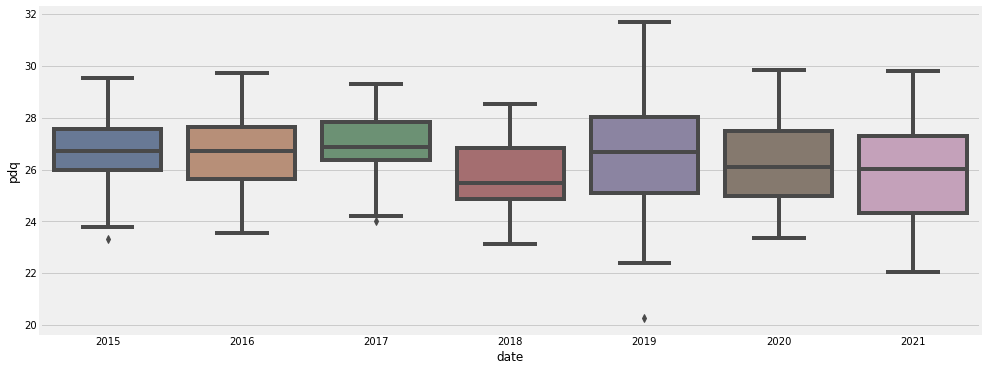

In [11]:
# diagrama de caja y bigotes
fig, ax = plt.subplots(figsize=(15,6))
sns.boxplot(y_s1.pdq.index.year, y_s1.pdq, ax=ax)
plt.show()

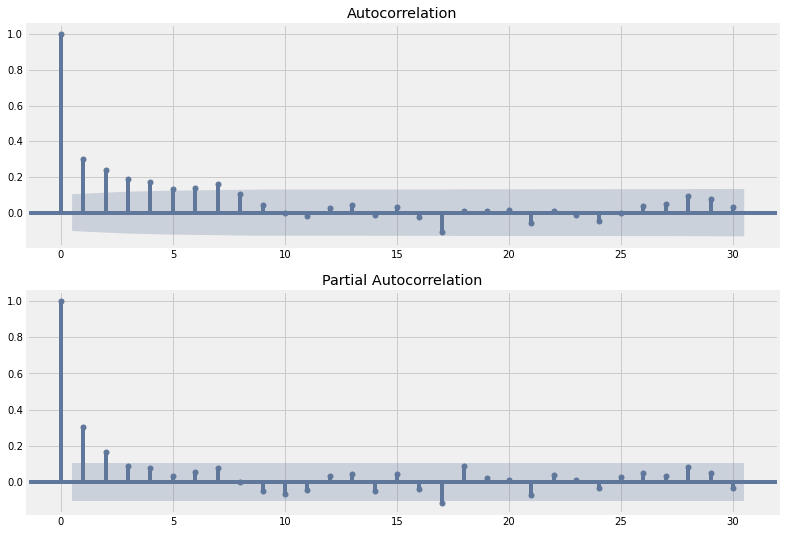

In [12]:
#ACF Y PACF para observar los lags significativos.
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot
pyplot.figure(figsize=(12,9))

# acf
pyplot.subplot(211)
plot_acf(y_s1.pdq, ax=pyplot.gca(), lags = 30)

#pacf
pyplot.subplot(212)
plot_pacf(y_s1.pdq, ax=pyplot.gca(), lags = 30)
pyplot.show()

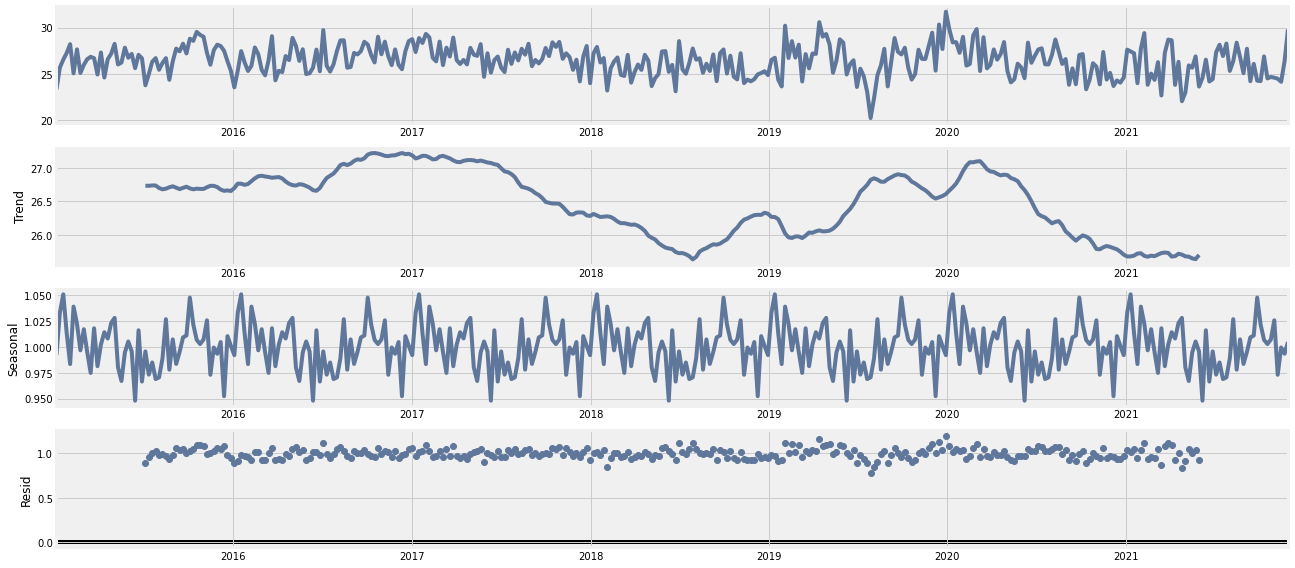

In [13]:
#Ahora procederemos a descomponer la serie de tiempo:
from pylab import rcParams
import statsmodels.api as sm
import matplotlib.pyplot as plt

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y_s1, model='multiplicative')
fig = decomposition.plot()
plt.show()

De estos graficos podemos sacar las siguientes conclusiones:
* Grafico 1: Es la grafica de la serie de tiempo.
* Grafico 2: Aqui se puede ver la tendencia de la serie, esta no tiene por decirlo de alguna forma una monotonia, en un momento  la tendencia es positiva y en otro negativa, se podria decir que es tipo "embudo"
* Grafico 3: Estacionaridad de la serie, en este caso es anual.
* Grafico 4: error de la serie, oscila entre 0 y 1


### Aplicar modelo de pronostico:

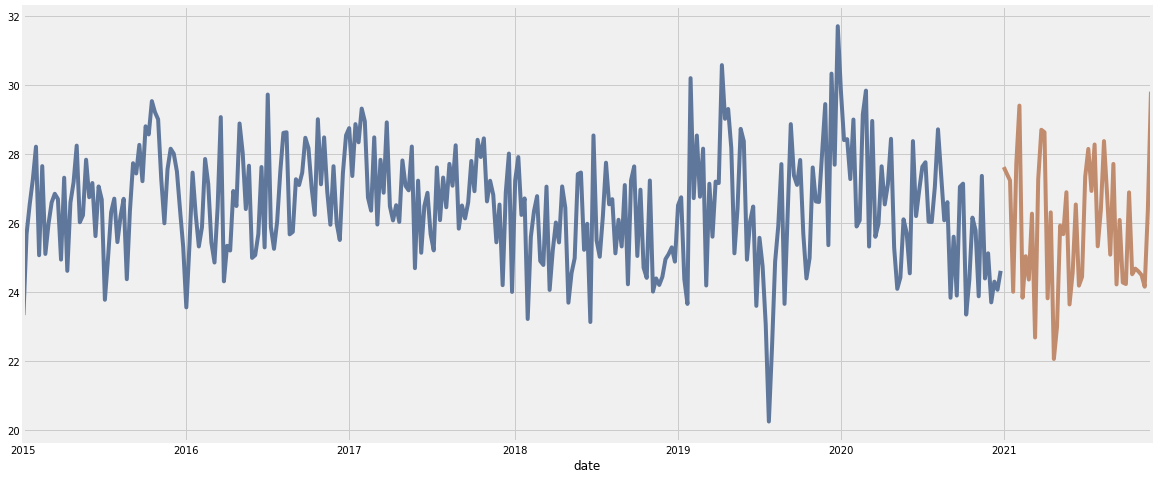

In [14]:
target_date =  '2021-01-01'

# crear conjunto de entrenamiento y de testeo
mask_ds = y_s1.index < target_date

y_train = y_s1[mask_ds]
y_test = y_s1[~mask_ds]

#plotting the data
y_train['pdq'].plot()
y_test['pdq'].plot()
plt.show()

In [15]:
#Ahora ajustaremos el modelo para los distintos parametros creados en
#la clase del modelo SARIMA
lista = [] #lista donde iremos almacenando las metricas del modelo para cada parametro
for p in params:
    try:
        model=SarimaModels(p)
        lista.append(model.metrics(y_s1,target_date))
    except:
        pass
#Juntamos las metricas de todos los modelos:
df_metrics = pd.concat(lista).reset_index()
df_metrics.head()

,index,mae,mse,rmse,mape,maape,wmape,mmape,smape,model
0,0,25.8768,672.9892,25.9420,1.0000,0.7854,1.0000,0.9626,2.0000,"SARIMA_(0,0,0)X(0,0,0,12)"
1,0,23.0209,560.5370,23.6757,0.8899,0.7147,0.8896,0.8567,1.7030,"SARIMA_(0,0,0)X(0,0,1,12)"
2,0,1.9462,5.7418,2.3962,0.0735,0.0732,0.0752,0.0708,0.0760,"SARIMA_(0,0,0)X(0,1,0,12)"
3,0,1.6444,3.7832,1.9451,0.0654,0.0651,0.0635,0.0629,0.0635,"SARIMA_(0,0,0)X(0,1,1,12)"
4,0,2.1228,6.5897,2.5670,0.0799,0.0795,0.0820,0.0770,0.0834,"SARIMA_(0,0,0)X(1,0,0,12)"


In [16]:
#reordenamos para ver el con menor mape:
df_metrics.sort_values(['mape']).head()

,index,mae,mse,rmse,mape,maape,wmape,mmape,smape,model
5,0,1.5876,3.4224,1.8500,0.0622,0.0620,0.0614,0.0599,0.0614,"SARIMA_(0,0,0)X(1,0,1,12)"
13,0,1.5934,3.4304,1.8521,0.0624,0.0622,0.0616,0.0600,0.0616,"SARIMA_(0,0,1)X(1,0,1,12)"
37,0,1.6021,3.4537,1.8584,0.0627,0.0625,0.0619,0.0603,0.0619,"SARIMA_(1,0,0)X(1,0,1,12)"
6,0,1.6924,4.4958,2.1203,0.0646,0.0643,0.0654,0.0622,0.0655,"SARIMA_(0,0,0)X(1,1,0,12)"
56,0,1.7335,4.7229,2.1732,0.0646,0.0644,0.0670,0.0623,0.0672,"SARIMA_(1,1,1)X(0,0,0,12)"


In [18]:
#El mejor modelo es el de parametros:
parametros=[(0,0,0), (1,0,1,12)]

Veamos que tal el grafico el ajuste de este modelo:

In [21]:
#veamos que tal el grafico de este modelo:
sarima_model =  SarimaModels(parametros)
model_fit = sarima_model.fit_model(y_s1,target_date)
best_model = sarima_model.df_testig(y_s1,target_date)
best_model.head()

,y,yhat
2021-01-03,27.622449,26.158298
2021-01-10,27.425532,25.926903
2021-01-17,27.235294,26.083721
2021-01-24,24.012658,26.308888
2021-01-31,27.716418,26.074931


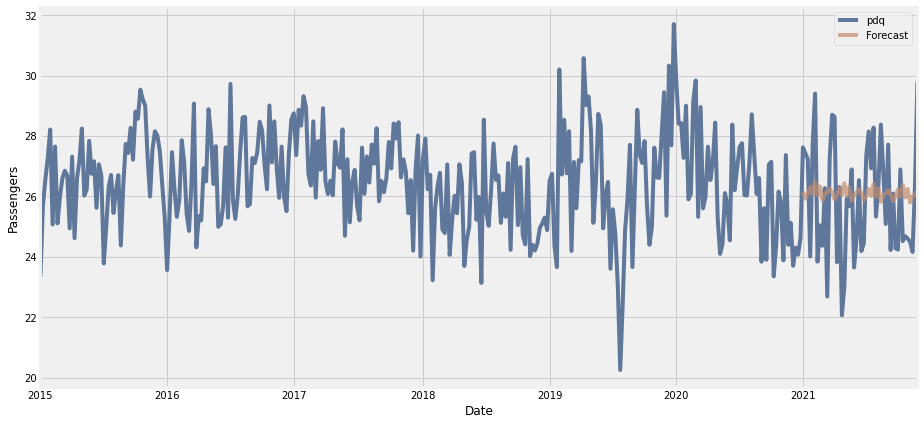

In [25]:
 # graficar mejor modelo

preds = best_model['yhat']
ax = y_s1['1949':].plot(label='observed')
preds.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))
ax.set_xlabel('Date')
ax.set_ylabel('Passengers')
plt.legend()
plt.show()

Se concluye que el ajuste de este modelo no es el ideal

### Veamos que el error es un ruido blanco :

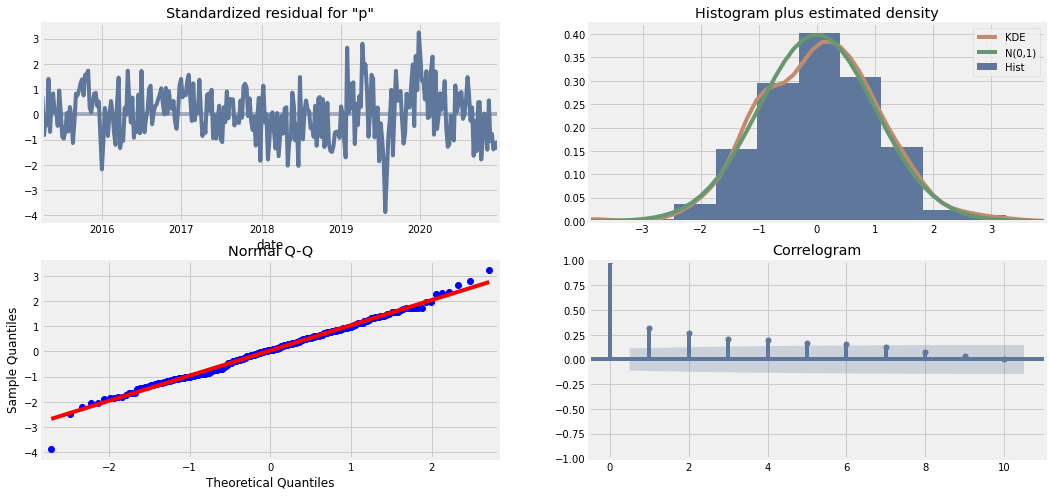

In [26]:
# resultados del error 
model_fit.plot_diagnostics(figsize=(16, 8))
plt.show()

* gráfico 01 (standarized residual): Este gráfico nos muestra el error estandarizado en el tiempo. En este caso se observa que esta nueva serie de tiempo corresponde a una serie estacionaria que oscila entorno al cero, es decir, un ruido blanco.

* gráfico 02 (histogram plus estimated density): Este gráfico nos muestra el histograma del error. En este caso, el histograma es muy similar al histograma de una variable N(0,1) (ruido blanco).

* gráfico 03 (normal QQ):  el gráfico Q-Q ("Q" viene de cuantil) es un método gráfico para el diagnóstico de diferencias entre la distribución de probabilidad de una población de la que se ha extraído una muestra aleatoria y una distribución usada para la comparación. En este caso se comparar la distribución del error versus una distribución normal. Cuando mejor es el ajuste lineal sobre los puntos, más parecida es la distribución entre la muestra obtenida y la distribución de prueba (distribución normal).

* gráfico 04 (correlogram): Este gráfico nos muestra el gráfico de autocorrelación entre las variables del error, se observa que no hay correlación entre ninguna de las variables, por lo que se puedan dar indicios de independencia entre las variables.

    En conclusion el error es un ruido blanco